In [ ]:
## This is a series of examples using the icanswim/cosmosis data science and machine learning repo

In [1]:
from model import FFNet, tv_model
from learning import Learn, Selector, Metrics
from dataset import CDataset, SKDS, TVDS
from dataset import ImageDatasetStats, AsTensor, Squeeze, DType

from torch.optim import Adam
from torch.nn import MSELoss, CrossEntropyLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms

In [ ]:
## Example of generic/custom dataset and transforms
import numpy as np

class DummyDataset(CDataset):

    def load_data(self, boom='bust'):
        
        datadic = {1: {'feature_1': np.asarray([.04]),
                       'feature_2': np.asarray([.02]),
                       'feature_3': np.asarray(['z1']),
                       'feature_4': np.asarray(['c','c','d']),
                       'feature_5': np.asarray([1.1])},
                   2: {'feature_1': np.asarray([.03]),
                       'feature_2': np.asarray([.01]),
                       'feature_3': np.asarray(['x1','z1','y1']),
                       'feature_4': np.asarray(['d','a','d']),
                       'feature_5': np.asarray([1.2])}}
        
        self.embed_lookup = {'feature_4': {'a': 1,'b': 2,'c': 3,'d': 4, '0': 0},
                             'feature_3': {'z1': 1, 'y1': 2, 'x1': 3, '0': 0}}
        
        print(boom)
        return datadic
    
class DummyTransform():
    def __call__(self, arr):
        return np.add(arr, 2)
    
class DummyTransformTwo():
    def __call__(self, arr):
        return np.multiply(arr, .1)
    
ds_params = {'train_params': {'input_dict': {'model_input': {'X1': ['feature_1','feature_5'],
                                                              'X2': ['feature_5'],
                                                              'embed': ['feature_3']},
                                             'criterion_input': {'y': ['feature_2'],
                                                                  'embed': ['feature_4']}},
                              'transform': [DummyTransform(), DummyTransformTwo()],
                              'target_transform': [],
                              'pad': 5,
                              'pad_feats': ['feature_5','feature_4'],
                              'boom': 'bang'}}
    
d = DummyDataset(**ds_params['train_params'])
d[2]

In [ ]:
## Example of sklearn regression dataset wrapper
ds_params = {'train_params': {'input_dict': {'model_input': {'features': ['X']},
                                             'criterion_input': {'targets': ['y']}},
                              'dataset': 'make_regression',
                              'sk_params': {'n_samples': 100,
                                            'n_features': 5},
                              'features_dtype': 'float32',
                              'targets_dtype': 'float32'}}

sk = SKDS(**ds_params['train_params'])

sk[1]

In [ ]:
## Example of sklearn classification dataset wrapper
ds_params = {'train_params': {'input_dict': {'model_input': {'features': ['X']},
                                             'criterion_input': {'targets': ['y']}},
                              'dataset': 'make_classification',
                              'features_dtype': 'float32',
                              'targets_dtype': 'int64',
                              'sk_params': {'n_samples': 100,
                                            'n_features': 10,
                                            'n_informative': 8,
                                            'n_clusters_per_class': 2,
                                            'flip_y': 0.05,
                                            'class_sep': 0.01,
                                            'n_classes': 4}}}

sk = SKDS(**ds_params['train_params'])

sk[1]

In [ ]:
## Example of torchvision wrapper
ds_params={'dataset': 'MNIST',
           'input_dict': {'model_input': {'features': ['images'],},
                          'criterion_input': {'targets': ['labels']}},
           'tv_params': {'root': './data/',
                         'train': True,
                         'download': True,
                         'transform': transforms.Compose([
                                           transforms.Resize(224)]),
                         'target_transform': None}}

tvds = TVDS(**ds_params)
tvds[1]

In [ ]:
## Example of torchvision dataset wrapper with PIL transform
ds_params={'dataset': 'MNIST',
           'tv_params': {'root': './data/',
                         'train': True,
                         'download': True,
                         'transform': transforms.Compose([
                                           transforms.Resize(224)]),
                         'target_transform': None}}

tvds = TVDS(**ds_params)
ids = ImageDatasetStats(tvds)

print('mean: ', ids.stats.mean)
print('stddev: ', ids.stats.stddev)

#mean: 33.3/255 = .13
#stddev: 73.7/255 = .29

creating scikit learn make_regression dataset...
CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:02.589537
epoch: 0, lr: 0.01
train loss: 544149.2013888889, val loss: 436439.10511363635
test loss: 13338.430841619318
learning time: 0:00:09.122587


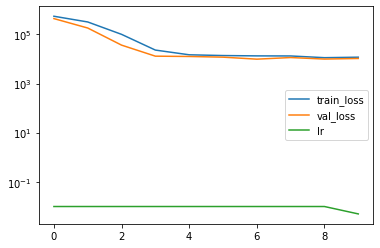

In [2]:
## Example sklearn regression dataset wrapper with custom model
model_params = {'D_in': 256, 
                'H': 512, 
                'D_out': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['X']},
                                             'criterion_input': {'target': ['y']}},
                              'features_dtype': 'float32',
                              'targets_dtype': 'float32',
                              'dataset': 'make_regression',
                              'as_tensor': True,
                              'transform': [],
                              'sk_params': {'n_samples':20000,
                                            'n_features': 256,
                                            'n_informative': 200}}}
             
metrics_params = {'report_interval': 10,
                  'log_plot': True}                         
             
opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 2}

l = Learn([SKDS], 
          FFNet,
          Metrics=Metrics,
          Sampler=Selector, 
          Optimizer=Adam, 
          Scheduler=ReduceLROnPlateau, 
          Criterion=MSELoss,
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params, 
          batch_size=256, epochs=10, gpu=True)

In [ ]:
## Example sklearn classification dataset and metrics wrapper with custom model
model_params = {'D_in': 256, 
                'H': 128, 
                'D_out': 4, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'features': 'X',
                              'targets': 'y',
                              'features_dtype': 'float32',
                              'targets_dtype': 'int64',
                              'dataset': 'make_classification',
                              'sk_params': {'n_samples': 100000,
                                            'n_features': 300,
                                            'n_informative': 200,
                                            'n_clusters_per_class': 3,
                                            'flip_y': 0.05,
                                            'class_sep': 0.1,
                                            'n_classes': 4}}}
                                     
metrics_params = {'report_interval': 10, 
                  'sk_metric_name': 'roc_auc_score',
                  'sk_params': {'average': 'macro',
                                'multi_class': 'ovr'}}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 5}

l = Learn([SKDS], 
          FFNet, 
          Sampler=Selector,
          Metrics=Metrics,
          Optimizer=Adam, 
          Scheduler=ReduceLROnPlateau, 
          Criterion=CrossEntropyLoss,
          model_params=model_params, ds_params=ds_params, 
          sample_params=sample_params, opt_params=opt_params, 
          sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          adapt=(300,256,.2), batch_size=128, epochs=10, squeeze_y=True, save_model=True)

In [ ]:
## Example inference with a sklearn classification dataset and metrics wrapper with custom model
model_params = {'D_in': 256, 
                'H': 128, 
                'D_out': 4, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'features': 'X',
                              'targets': 'y',
                              'features_dtype': 'float32',
                              'targets_dtype': 'int64',
                              'dataset': 'make_classification',
                              'sk_params': {'n_samples': 10000,
                                            'n_features': 300,
                                            'n_informative': 200,
                                            'n_clusters_per_class': 3,
                                            'flip_y': 0.05,
                                            'class_sep': 0.1,
                                            'n_classes': 4}}}
                                     
metrics_params = {'report_interval': 10, 
                  'sk_metric_name': 'roc_auc_score',
                  'sk_params': {'average': 'macro',
                                'multi_class': 'ovr'}}

opt_params = {'lr': 0.01}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 5}

l = Learn([SKDS], 
          FFNet, 
          Sampler=Selector,
          Metrics=Metrics,
          Optimizer=Adam, 
          Scheduler=ReduceLROnPlateau, 
          Criterion=None,
          model_params=model_params, ds_params=ds_params, 
          sample_params=sample_params, opt_params=opt_params, 
          sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=128, epochs=1, squeeze_y=True, load_model='20220813_2127.pth')

In [ ]:
## Example torchvision dataset, transforms and model wrapper
model_params = {'model_name': 'resnet18',
                'in_channels': 3,
                'tv_params': {'num_classes': 10}}

ds_params={'train_params': {'dataset': 'CIFAR10',
                            'tv_params': {'root': './data/',
                                          'train': True,
                                          'download': True,
                                          'transform': transforms.Compose([
                                                           transforms.RandomRotation(10),
                                                           transforms.Resize(64),
                                                           transforms.ToTensor()]),
                                          'target_transform': None,
                                          'download': True}},
           'test_params': {'dataset': 'CIFAR10',
                           'tv_params': {'root': './data/',
                                         'train': False,
                                         'download': True,
                                         'transform': transforms.Compose([
                                                         transforms.Resize(64),
                                                         transforms.ToTensor()]),
                                         'target_transform': None,
                                         'download': True}}}

metrics_params = {'report_interval': 10, 
                  'sk_metric_name': 'roc_auc_score', 
                  'sk_params': {'average': 'macro',
                                'multi_class': 'ovr'}}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.8,),
                 'subset': .1}

sched_params = {'factor': .5,
                'patience': 1,
                'cooldown': 1}

l = Learn([TVDS,TVDS], 
          tv_model, 
          Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=CrossEntropyLoss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params, 
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params, 
          batch_size=16, epochs=4)

In [ ]:
## Example torchvision dataset and model wrapper
model_params = {'model_name': 'resnext50_32x4d',
                'in_channels': 3,
                'tv_params': {'num_classes': 10}}

ds_params={'train_params': {'dataset': 'CIFAR10',
                            'tv_params': {'root': './data/',
                                          'train': True,
                                          'transform': transforms.Compose([
                                                       transforms.RandomRotation(10),
                                                       transforms.Resize(256),
                                                       transforms.ToTensor()]),
                                          'target_transform': None}},
           'test_params': {'dataset': 'CIFAR10',
                           'tv_params': {'root': './data/',
                                         'train': False,
                                         'transform': transforms.Compose([
                                                      transforms.Resize(256),
                                                      transforms.ToTensor()]),
                                         'target_transform': None}}}

metrics_params = {'report_interval': 10, 
                  'sk_metric_name': 'roc_auc_score', 
                  'sk_params': {'average': 'macro',
                                'multi_class': 'ovr'}}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.8,),
                 'subset': .1}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 2}

l = Learn([TVDS,TVDS], 
          tv_model, 
          Selector, 
          Optimizer=Adam, 
          Scheduler=ReduceLROnPlateau, 
          Criterion=CrossEntropyLoss, 
          model_params=model_params, ds_params=ds_params, 
          sample_params=sample_params, opt_params=opt_params, 
          sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=16, epochs=4)